# Set up and Read in Data

In [1]:
import keras
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.layers import Layer, Input, Dense, Concatenate, Conv2D, Reshape,  Embedding
from keras.layers import MaxPooling1D, Flatten, BatchNormalization, Activation, Dropout

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

import matplotlib as mpl
%matplotlib inline

from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from IPython.display import Image

import seaborn as sns
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
print(keras.__version__)

2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_FILE_PATH = 'drive/MyDrive/4B Projects/MSCI 598 (Deep Learning for NLP) Project/Code'

df_train = pd.read_csv(DATA_FILE_PATH+"/train.csv")
df_val = pd.read_csv(DATA_FILE_PATH+"/val.csv")
df_test = pd.read_csv(DATA_FILE_PATH+"/test.csv")

In [5]:
# Print number in each group.
print("Training: ", len(df_train))
print("Val: ", len(df_val))
print("Test: ", len(df_test))

Training:  50971
Val:  6471
Test:  4621


In [ ]:
# To get reproducible results.
from numpy.random import seed
seed(598)

# Hyperparameters

In [ ]:
EMB_DIR = 'drive/MyDrive/4B Projects/MSCI 598 (Deep Learning for NLP) Project/Code/glove.6B.50d.txt'

MAX_VOCAB_SIZE = 10000
MAX_SENT_LEN = 12
EMBEDDING_DIM = 50
BATCH_SIZE = 64
N_EPOCHS = 20

# Preprocessing

In [ ]:
print('Train dataset size:', df_train.shape)

# Convert all values in text column to string.
df_train["text"] = df_train["text"].apply(lambda x: str(x))
df_val["text"] = df_val["text"].apply(lambda x: str(x))
df_test["text"] = df_test["text"].apply(lambda x: str(x))

Train dataset size: (50971, 10)


#### Delete Small and Long Texts

In [ ]:
df_train['text_length'] = df_train["text"].apply(lambda x: len(x))
df_train[df_train['text_length']<10]['text']

3        She okay?
4        Let's go.
5              Wow
7               No
17           No...
           ...    
50950       I know
50959          nan
50961           Oh
50962         Yes.
50963         Four
Name: text, Length: 13546, dtype: object

In [ ]:
# Questions having lesser than 10 characters can be discarded. 
indices = set(df_train[df_train['text_length']<10].index)

df_train.drop(indices, inplace=True)
df_train.reset_index()

# Can drop the character count columns - to save memory
df_train.drop(['text_length'], inplace=True, axis=1)

In [ ]:
# THIS IS HOW WE GOT MAX_SENT_LEN = 12
word_count = lambda x:len(x.split()) # Word count for each utterance
df_train['text_wc'] = df_train.text.str.split().str.len()

p = 80.0

print('Text :{} % of the sentences have a length less than or equal to {}'.format(p, np.nanpercentile(df_train['text_wc'], 80)))

Text :80.0 % of the sentences have a length less than or equal to 11.0


#### Equalise values in each category

In [ ]:
def equalize_category(category):
  print("Before Equalize:")
  print(df_train[category].value_counts())
  
  min_count = min(df_train[category].value_counts())

  neg = df_train[df_train[category] == 0][:min_count]
  pos = df_train[df_train[category] == 1][:min_count]

  df_train_category = pd.concat([neg, pos])
  df_train_category = df_train_category.sample(frac=1).reset_index(drop=True) # shuffling

  print("\nAfter Equalize:")
  print(df_train_category[category].value_counts())

  return df_train_category

In [ ]:
df_train_IE = equalize_category("IE")

Before Equalize:
1    19635
0    17790
Name: IE, dtype: int64

After Equalize:
0    17790
1    17790
Name: IE, dtype: int64


In [ ]:
df_train_NS = equalize_category("NS")

Before Equalize:
0    19709
1    17716
Name: NS, dtype: int64

After Equalize:
1    17716
0    17716
Name: NS, dtype: int64


In [ ]:
df_train_TF = equalize_category("TF")

Before Equalize:
0    22022
1    15403
Name: TF, dtype: int64

After Equalize:
1    15403
0    15403
Name: TF, dtype: int64


In [ ]:
df_train_JP = equalize_category("JP")

Before Equalize:
0    22146
1    15279
Name: JP, dtype: int64

After Equalize:
0    15279
1    15279
Name: JP, dtype: int64


#### Tokenizing

Better to use NLTK tokenizer first and then Keras word to indices.

We can concatenate NLTK tokens with whitespace (" ".join(...)) and then use keras Tokenizer 


---

Keras will do this : 'what is this?' -> ['what', 'is', 'this?']

NLTK will do this : 'what is this?' -> ['what', 'is', 'this', '?']


In [ ]:
def tokenize_category_text(df_train):
  text_list = list(df_train['text'])
  text_list = [' '.join(word_tokenize(q)[:MAX_SENT_LEN]) for q in text_list]

  # Filters
  tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#?$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n') 
  tokenizer.fit_on_texts(text_list)

  print("Number of words in vocabulary:", len(tokenizer.word_index))

  # Limit vocab and idx-word dictionary
  word_index =  word_index = {k: v for k, v in tokenizer.word_index.items() if v < MAX_VOCAB_SIZE}
  idx_to_word = dict((v,k) for k,v in word_index.items())

  X_train = tokenizer.texts_to_sequences(text_list)
  X_train = pad_sequences(X_train, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

  return X_train, word_index, tokenizer

In [ ]:
X_train_IE, word_index_IE, tokenizer_IE = tokenize_category_text(df_train_IE)

Number of words in vocabulary: 11393


In [ ]:
X_train_NS, word_index_NS,tokenizer_NS = tokenize_category_text(df_train_NS)

Number of words in vocabulary: 11435


In [ ]:
X_train_TF, word_index_TF, tokenizer_TF = tokenize_category_text(df_train_TF)

Number of words in vocabulary: 10683


In [ ]:
X_train_JP, word_index_JP, tokenizer_JP = tokenize_category_text(df_train_JP)

Number of words in vocabulary: 10445


# Embedding Matrix

In [ ]:
# Load GloVe word embeddings 
# Download Link: https://nlp.stanford.edu/projects/glove/

print("[INFO]: Reading Word Embeddings ...")
# Data path
embeddings = {}
f = open(EMB_DIR)
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings[word] = vector
f.close()

[INFO]: Reading Word Embeddings ...


In [ ]:
def create_embedding_matrix(word_index):
  # Create an embedding matrix containing only the word's in our vocabulary
  # If the word does not have a pre-trained embedding, then randomly initialize the embedding
  embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

  for word, i in word_index.items(): # i=0 is the embedding for the zero padding
      try:
          embeddings_vector = embeddings[word]
      except KeyError:
          embeddings_vector = None
      if embeddings_vector is not None:
          embeddings_matrix[i] = embeddings_vector
  return embeddings_matrix

# CNN with Keras Model API

In [ ]:
# Bigram and trigram filters
bi_filter_size = 2
tri_filter_size = 3

num_filters = 20

In [ ]:
def make_CNN_model(embeddings_matrix):
  input_1 = Input(shape=(MAX_SENT_LEN, ), name='text_input')

  # Common embedding lookup layer
  emb_look_up = Embedding(input_dim=MAX_VOCAB_SIZE,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], 
                          trainable=False, 
                          mask_zero=False,
                          name='text_embedding_lookup')

  emb_1 = emb_look_up(input_1)

  # Need to be reshaped because the CONV layer assumes 1 dimension as num of channels
  emb_1 = Reshape(target_shape=(1, MAX_SENT_LEN, EMBEDDING_DIM), 
                  name='text_embedding_reshape')(emb_1) 

  # Convolutional Layers
  conv_1_bi =  Conv2D(filters=num_filters, 
                      kernel_size=(bi_filter_size, EMBEDDING_DIM), 
                      padding='valid', 
                      activation='relu', 
                      data_format='channels_first', 
                      name='text_bigram_conv')(emb_1)

  conv_1_tri =  Conv2D(filters=num_filters, 
                      kernel_size=(tri_filter_size, EMBEDDING_DIM), 
                      padding='valid', 
                      activation='relu', 
                      data_format='channels_first', 
                      name='text_trigram_conv')(emb_1)

  # Remove channel dimension before max-pooling operation
  bi_out_timesteps = MAX_SENT_LEN - bi_filter_size + 1
  tri_out_timesteps = MAX_SENT_LEN - tri_filter_size + 1

  conv_1_bi = Reshape(target_shape=(bi_out_timesteps, num_filters), 
                      name='text_bigram_conv_reshape')(conv_1_bi) # (MAX_SENT_LEN - bi_filter_size + 1, num_filters)
  conv_1_tri = Reshape(target_shape=(tri_out_timesteps, num_filters), 
                      name='text_trigram_conv_reshape')(conv_1_tri)

  # Max-pooling Layer
  # Pool across timesteps to get 1 feature per filter, i.e., each filter captures 1 feature about the sentence/question
  max_pool_1_bi = MaxPooling1D(pool_size = bi_out_timesteps, 
                              name='text_bigram_maxpool')(conv_1_bi)
  max_pool_1_tri = MaxPooling1D(pool_size = tri_out_timesteps, 
                                name='text_trigram_maxpool')(conv_1_tri)

  # Merge the features learnt by bi and tri filters
  merged_1 = Concatenate(name='text_maxpool_concat')([max_pool_1_bi, max_pool_1_tri])
  # Inputs dropped out randomly so that there is no heavy dependence on specific features for prediction
  dropout_1 = Dropout(rate=0.2, 
                      name='text_dropout')(merged_1)
  flatten_1 = Flatten(name='text_flatten')(dropout_1)

  # Dense layers
  dense_1 = Dense(units=10, 
                  name='text_dense')(flatten_1)
  bn_1 = BatchNormalization(name='batchnorm')(dense_1)
  relu_1 = Activation(activation='relu', 
                      name='relu_activation')(bn_1)
  dense_1_dropout = Dropout(0.2, 
                            name='dense_dropout')(relu_1)

  output_prob = Dense(units=1, 
                      activation='sigmoid', 
                      name='output_layer')(dense_1_dropout)

  model = Model(inputs=[input_1], outputs=output_prob, name='text_pair_cnn')
  model.summary()

  plot_model(model, to_file='text_pair_cnn_classifier.png', show_layer_names=True)
  Image('text_pair_cnn_classifier.png')

  return model

In [ ]:
def txt_to_indx(txt, tokenizer):
  txt = tokenizer.texts_to_sequences(txt)
  txt = pad_sequences(txt, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

  return txt

# Run Models


In [ ]:
def run_category_model(category):
  df_train_category = equalize_category(category)

  X_train, word_index, tokenizer = tokenize_category_text(df_train_category)

  embeddings_matrix = create_embedding_matrix(word_index)

  model = make_CNN_model(embeddings_matrix)

  X_val = txt_to_indx(df_val["text"], tokenizer)

  y_train_category = df_train_category[category]
  y_val_category = df_val[category]

  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  model.fit(x = X_train, 
            y = y_train_category, 
            batch_size=BATCH_SIZE, 
            epochs=N_EPOCHS, 
            validation_data=(X_val, y_val_category))
  
  # Save model.
  model.save(DATA_FILE_PATH+f"/cnn_models/{category}_model")
  
  X_test = txt_to_indx(df_test["text"], tokenizer)
  y_test_category = df_test[category]

  # Predict on test set and compute accuracy.
  y_pred_category = model.predict(X_test)
  y_pred_category = np.where(y_pred_category > 0.5, 1, 0)

  accuracy = accuracy_score(y_test_category, y_pred_category)

  print("* Accuracy: %.2f%%" % (accuracy * 100.0))

  # Plot confusion matrix
  ax = plt.subplot()
  cm = confusion_matrix(y_test_category, y_pred_category)
  f = sns.heatmap(cm, annot=True, fmt='d')
  ax.set_xlabel('Predicted label')
  ax.set_ylabel('True label')

  return model, accuracy, tokenizer

#### Using the model

Before Equalize:
1    19635
0    17790
Name: IE, dtype: int64

After Equalize:
1    17790
0    17790
Name: IE, dtype: int64
Number of words in vocabulary: 11393
Model: "text_pair_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 12)]         0           []                               
                                                                                                  
 text_embedding_lookup (Embeddi  (None, 12, 50)      500000      ['text_input[0][0]']             
 ng)                                                                                              
                                                                                                  
 text_embedding_reshape (Reshap  (None, 1, 12, 50)   0           ['text_embedding_lookup[0][0]']  
 e)                     

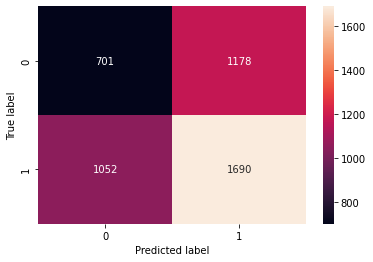

In [ ]:
ie_model, ie_accuracy, ie_tokenizer = run_category_model("IE")

Before Equalize:
0    19709
1    17716
Name: NS, dtype: int64

After Equalize:
0    17716
1    17716
Name: NS, dtype: int64
Number of words in vocabulary: 11435
Model: "text_pair_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 12)]         0           []                               
                                                                                                  
 text_embedding_lookup (Embeddi  (None, 12, 50)      500000      ['text_input[0][0]']             
 ng)                                                                                              
                                                                                                  
 text_embedding_reshape (Reshap  (None, 1, 12, 50)   0           ['text_embedding_lookup[0][0]']  
 e)                     

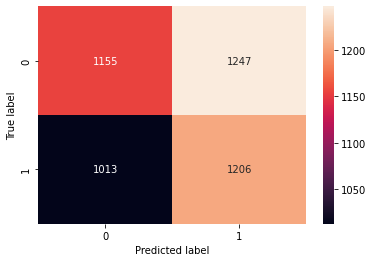

In [ ]:
ns_model, ns_accuracy, ns_tokenizer = run_category_model("NS")

Before Equalize:
0    22022
1    15403
Name: TF, dtype: int64

After Equalize:
1    15403
0    15403
Name: TF, dtype: int64
Number of words in vocabulary: 10683
Model: "text_pair_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 12)]         0           []                               
                                                                                                  
 text_embedding_lookup (Embeddi  (None, 12, 50)      500000      ['text_input[0][0]']             
 ng)                                                                                              
                                                                                                  
 text_embedding_reshape (Reshap  (None, 1, 12, 50)   0           ['text_embedding_lookup[0][0]']  
 e)                     

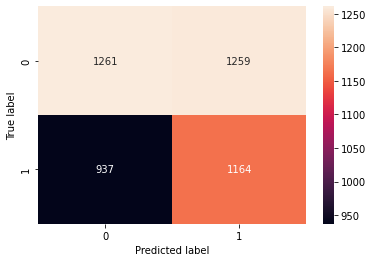

In [ ]:
tf_model, tf_accuracy, tf_tokenizer = run_category_model("TF")

Before Equalize:
0    22146
1    15279
Name: JP, dtype: int64

After Equalize:
0    15279
1    15279
Name: JP, dtype: int64
Number of words in vocabulary: 10445
Model: "text_pair_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 12)]         0           []                               
                                                                                                  
 text_embedding_lookup (Embeddi  (None, 12, 50)      500000      ['text_input[0][0]']             
 ng)                                                                                              
                                                                                                  
 text_embedding_reshape (Reshap  (None, 1, 12, 50)   0           ['text_embedding_lookup[0][0]']  
 e)                     

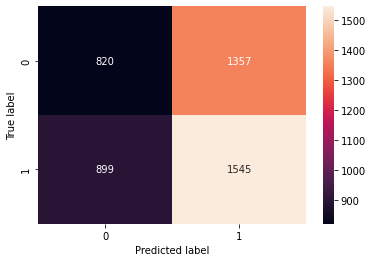

In [ ]:
jp_model, jp_accuracy, jp_tokenizer = run_category_model("JP")

### Accuracy Values

In [ ]:
# Macroaverage accuracy of the four classifiers.
macroavg_accuracy = (ie_accuracy + jp_accuracy + ns_accuracy + tf_accuracy) / 4
print("* Macroaverage Accuracy: %.2f%%" % (macroavg_accuracy * 100.0))

* Macroaverage Accuracy: 51.62%


In [6]:
# Microaverage accuracy of the four classifiers.
microavg_accuracy = ((701+1690)+(1155+1206)+(1261+1164)+(820+1545)) / (4*len(df_test))
print("* Microaverage Accuracy: %.2f%%" % (microavg_accuracy * 100.0))

* Microaverage Accuracy: 51.62%


In [ ]:
df_results = df_test

X_test_ie = txt_to_indx(df_test["text"], ie_tokenizer)
y_pred_ie = ie_model.predict(X_test_ie)
df_results["IE_pred"] = np.where(y_pred_ie > 0.5, 1, 0)

X_test_ns = txt_to_indx(df_test["text"], ns_tokenizer)
y_pred_ns = ns_model.predict(X_test_ns)
df_results["NS_pred"] = np.where(y_pred_ns > 0.5, 1, 0)

X_test_tf = txt_to_indx(df_test["text"], tf_tokenizer)
y_pred_tf = tf_model.predict(X_test_tf)
df_results["TF_pred"] = np.where(y_pred_tf > 0.5, 1, 0)

X_test_jp = txt_to_indx(df_test["text"], jp_tokenizer)
y_pred_jp = jp_model.predict(X_test_jp)
df_results["JP_pred"] = np.where(y_pred_jp > 0.5, 1, 0)

full_match = df_results[(df_results["IE"] == df_results["IE_pred"]) & (df_results["NS"] == df_results["NS_pred"]) & (df_results["TF"] == df_results["TF_pred"]) & (df_results["JP"] == df_results["JP_pred"])].count()["text"]
print("* Full Match Accuracy: %.2f%%" % (full_match/len(df_test) * 100.0))

* Full Match Accuracy: 6.41%
